In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm, vhmm
""" from sklearn.preprocessing import LabelEncoder
from scipy import interpolate """
import joblib

# Import data

Chargement des corrdonnées des oreilles 

In [2]:
X_ear = pd.pandas.read_csv("../data/ear_position.csv",  header=None)
X_ear


,0,1,2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
1370,0.0,0.0,1.0
1371,0.0,0.0,1.0
1372,0.0,0.0,1.0
1373,0.0,0.0,1.0


Text(0.5, 0.98, 'Ear Position')

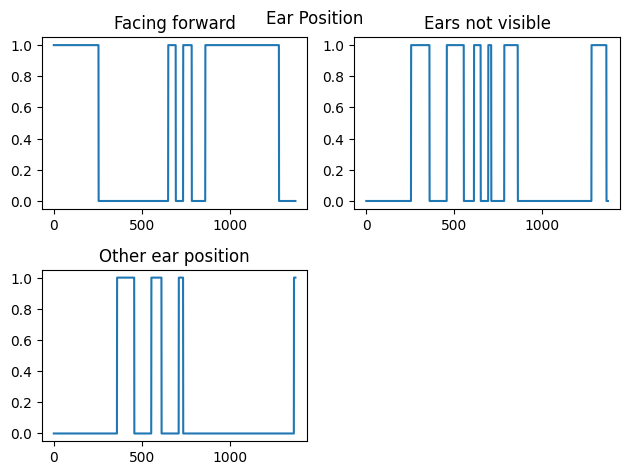

In [3]:
plt.subplot(2,2,1)
plt.plot(range(0,len(X_ear)) , X_ear[0])
plt.title('Facing forward')
plt.subplot(2,2,2)
plt.plot(range(0,len(X_ear)) ,X_ear[1])
plt.title('Ears not visible')
plt.subplot(2,2,3)
plt.plot(range(0,len(X_ear)) ,X_ear[2])
plt.title('Other ear position')
plt.tight_layout()
plt.suptitle('Ear Position')


0    0.557091
1    0.304727
2    0.138182
dtype: float64


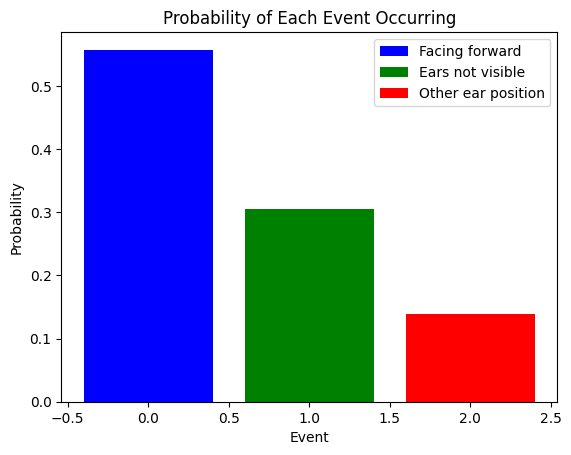

In [4]:
df = pd.DataFrame(X_ear)
df

# Calculate the probability for each event (column)
event_probabilities = df.mean()  # Calculate the mean of each column to get the probability
print(event_probabilities)

# Plot the probabilities
bars = plt.bar(event_probabilities.index, event_probabilities.values, color=['blue', 'green', 'red'])
plt.xlabel('Event')
plt.ylabel('Probability')
plt.title('Probability of Each Event Occurring')

plt.legend(handles=bars, labels=['Facing forward', 'Ears not visible', 'Other ear position'])
plt.show()

Lissage des donnees

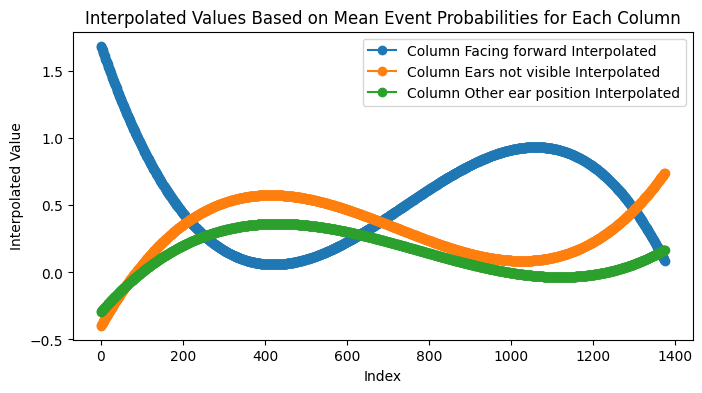

In [5]:

# Perform linear interpolation

labels=['Facing forward', 'Ears not visible', 'Other ear position']

# Perform interpolation based on the mean event probabilities for each column
interpolated_values = {}
x = np.arange(len(df))
for col in df.columns:
    poly = np.poly1d(np.polyfit(x, df[col], 3)) 
    interpolated_values[col] = poly(x)

for key,n_key in zip(interpolated_values.keys(), labels):
    interpolated_values[n_key] = interpolated_values.pop(key)

# Plot the interpolated values for each column separately
plt.figure(figsize=(8, 4))
for col, values in interpolated_values.items():
    plt.plot(values, label=f'Column {col} Interpolated', marker='o')
plt.xlabel('Index')
plt.ylabel('Interpolated Value')
plt.title('Interpolated Values Based on Mean Event Probabilities for Each Column')
plt.legend()
plt.show()

# Train model

In [6]:

scores_EM = scores_VI = list()
models_EM = models_VI = list()
X_interpolated_ear = pd.DataFrame.from_dict(interpolated_values)
# print(X_interpolated_ear)
""" le = LabelEncoder()
model = hmm.MultinomialHMM(n_components=3, n_iter=100)
model.fit(np.array(X_ear)) """


for n_components in range(2, 5):
    for idx in range(10):  
        model_EM = hmm.GaussianHMM(n_components=n_components, random_state=idx, covariance_type = "diag", n_iter=50)
        #model_VI = vhmm.VariationalGaussianHMM(n_components=n_components, random_state=idx, covariance_type = "diag", n_iter=50)
        model_EM.fit(X_interpolated_ear)
        #model_VI.fit(X_interpolated_ear)
        models_EM.append(model_EM)
        scores_EM.append(model_EM.score(X_interpolated_ear))
        # print(f'Converged: {model.monitor_.converged}\t\t'f'Score: {scores[-1]}')

# get the best model
model_EM = models_EM[np.argmax(scores_EM)]
print(f'The best EM_model had a score of {max(scores_EM)} and 'f'{model_EM.n_components} components')

# use the Viterbi algorithm to predict the most likely sequence of states
# given the model

Z_EM = model_EM.predict(X_interpolated_ear)

# Save the model object to a file
joblib.dump(model_EM, 'models/EM/hmm_model_ear.pkl')
print(model_EM)


The best EM_model had a score of 5332.743582059371 and 4 components
GaussianHMM(n_components=4, n_iter=50, random_state=2)


[3 1 2 0]


Text(0.5, 0.98, 'Ear position')

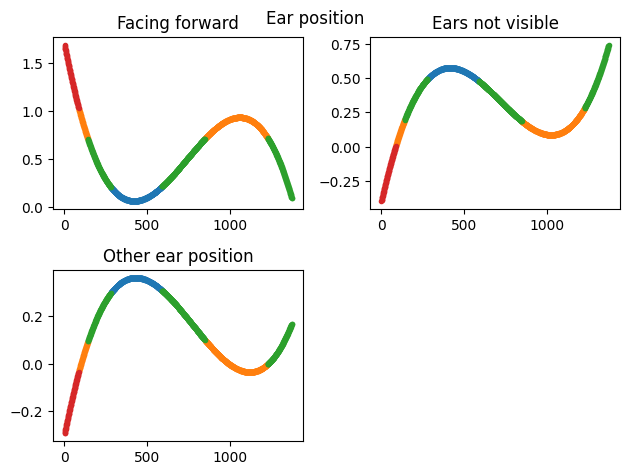

In [7]:
states_EM = pd.unique(Z_EM)
print(states_EM)

# Obtenir les probabilités de transition pour le prochain pas de temps (T+1)
prob_next_step = model_EM.transmat_[Z_EM[-1], :]


plt.subplot(2,2,1)
for i in range(0, len(states_EM)):
    x = np.linspace(1,1375,1375)[(Z_EM == i)]
    y = X_interpolated_ear['Facing forward'][(Z_EM == i)]
    plt.plot(x, y, '.')
    plt.title('Facing forward')
plt.subplot(2,2,2)
for i in range(0, len(states_EM)):
    x = np.linspace(1,1375,1375)[(Z_EM == i)]
    y = X_interpolated_ear['Ears not visible'][(Z_EM == i)]
    plt.plot(x, y, '.')
    plt.title('Ears not visible')
plt.subplot(2,2,3)
for i in range(0, len(states_EM)):
    x = np.linspace(1,1375,1375)[(Z_EM == i)]
    y = X_interpolated_ear['Other ear position'][(Z_EM == i)]
    plt.plot(x, y, '.')
    plt.title('Other ear position')

plt.tight_layout()
plt.suptitle('Ear position')

In [8]:


state_dict = {
    0: 'Relax',
    1: 'Observation',
    2: 'Fuite',
    3: 'Reminiscence'
}
replaced_array = [state_dict[value] for value in Z_EM]

df = pd.DataFrame({'states': replaced_array})
df.to_csv("../INF889E Project/Trained data/EM/ear_coords_hmmstates.csv")